In [12]:
import pandas as pd
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import ast

In [3]:
path_to_csv_files = r'C:\Users\gutzc\GitHub\human_micro_gesture_classifier\miga_dataset\SMG_RGB_Phase1\split_files_csv'

all_csv_files = glob(osp.join(path_to_csv_files, '*.csv'))
print(len(all_csv_files))

32


In [33]:
df_list = [pd.read_csv(p) for p in all_csv_files]
df = pd.concat(df_list)
# correct columns
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x))
df['multihot_labels'] = df['multihot_labels'].apply(lambda x: np.array(ast.literal_eval(x.replace(' ',','))))
print(len(df))
print(df.columns)
df.head()

3451
Index(['Unnamed: 0', 'file_name', 'start_frame', 'end_frame', 'labels',
       'multihot_labels', 'frame_numbers', 'source_folder', 'source_video'],
      dtype='object')


,Unnamed: 0,file_name,start_frame,end_frame,labels,multihot_labels,frame_numbers,source_folder,source_video
0,0,0001_000_00164-00228_14.mp4,100,164,[14],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[100, 101, 102, 103, 104, 105, 106, 107, 108, ...",C:\Users\gutzc\GitHub\human_micro_gesture_clas...,Sample0001_color.mp4
1,1,0001_001_00831-00895_14.mp4,164,228,[14],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[164, 165, 166, 167, 168, 169, 170, 171, 172, ...",C:\Users\gutzc\GitHub\human_micro_gesture_clas...,Sample0001_color.mp4
2,2,0001_002_01697-01761_11.mp4,831,895,[11],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[831, 832, 833, 834, 835, 836, 837, 838, 839, ...",C:\Users\gutzc\GitHub\human_micro_gesture_clas...,Sample0001_color.mp4
3,3,0001_003_04835-04899_11.mp4,1697,1761,[11],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1697, 1698, 1699, 1700, 1701, 1702, 1703, 170...",C:\Users\gutzc\GitHub\human_micro_gesture_clas...,Sample0001_color.mp4
4,4,0001_004_06317-06381_7.mp4,4835,4899,[7],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[4835, 4836, 4837, 4838, 4839, 4840, 4841, 484...",C:\Users\gutzc\GitHub\human_micro_gesture_clas...,Sample0001_color.mp4


In [34]:
# see labels distribution
all_labels = df.labels.values.tolist()

(array([  57.,   83.,  292.,   17., 1112.,   48.,  165.,  464., 1199.,
          21.,   19.,  294.,   79.,  104.,   18.,   40.,   73.]),
 array([ 0.        ,  0.94117647,  1.88235294,  2.82352941,  3.76470588,
         4.70588235,  5.64705882,  6.58823529,  7.52941176,  8.47058824,
         9.41176471, 10.35294118, 11.29411765, 12.23529412, 13.17647059,
        14.11764706, 15.05882353, 16.        ]),
 <BarContainer object of 17 artists>)

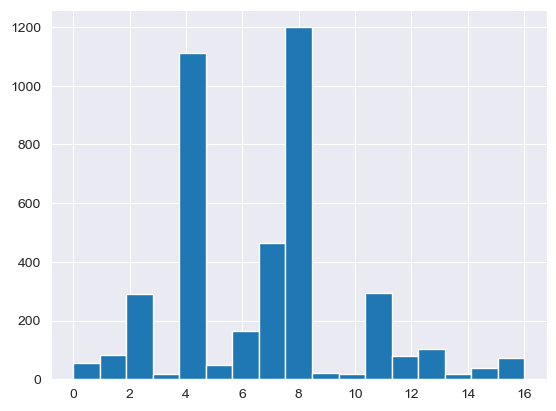

In [35]:
labels_flat = [a for sub in all_labels for a in sub]
plt.hist(labels_flat, bins=17)

In [46]:
from skmultilearn.model_selection import iterative_train_test_split
X = df['file_name'].values
X = X.reshape(-1,1)

y = df['multihot_labels'].values
y = np.stack(y)

X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.1)

In [57]:
# check out resutls
df_ind = df.set_index('file_name', drop=True)
df_train_raw = df_ind.loc[X_train.squeeze()]
df_val_raw = df_ind.loc[X_test.squeeze()]


In [58]:
print(df.columns)

Index(['Unnamed: 0', 'file_name', 'start_frame', 'end_frame', 'labels',
       'multihot_labels', 'frame_numbers', 'source_folder', 'source_video'],
      dtype='object')


In [59]:
# columns i need:
def convert_df(df_in):
        
    df_out = pd.DataFrame()
    
    df_out['filenames'] = df_in['file_name']
    df_out['folder_name'] = ''
    df_out['durations'] = 64
    
    df_out['view'] = 'center'
    metadata = pd.DataFrame()
        
    metadata['sample_id'] = df_out['filenames'].apply(lambda x: x.split('.')[0])
    metadata['start_frame'] = df_in['start_frame']
    metadata['end_frame'] = df_in['end_frame']
    metadata['label']= df_in['labels']
    metadata['view'] =  df_out['view']
    metadata['filenames'] = df_out['filenames']
    metadata['durations'] = df_out['durations']
    # cat = df_in['label']
    # categories = list(LABEL2ID.keys())
    # one_hot_encoded = pd.get_dummies(cat.astype(pd.CategoricalDtype(categories=categories)))
    
    # new_columns = one_hot_encoded.columns.to_list()
    # one_hot_encoded = one_hot_encoded.astype(float)
    df_out['labels'] = df_in['multihot_labels']
    # df_out['labels'] = df_in['label'] - 1
    df_out['metadata'] = metadata.to_dict(orient='records')
    
    return df_out

In [61]:
df_val = convert_df(df_in=df_val_raw.reset_index())
df_train = convert_df(df_in=df_train_raw.reset_index())

In [64]:
df_val.head()

,filenames,folder_name,durations,view,labels,metadata
0,0001_000_00164-00228_14.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0001_000_00164-00228_14', 'star..."
1,0001_003_04835-04899_11.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0001_003_04835-04899_11', 'star..."
2,0001_005_06437-06501_8.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","{'sample_id': '0001_005_06437-06501_8', 'start..."
3,0001_007_06547-06611_8.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","{'sample_id': '0001_007_06547-06611_8', 'start..."
4,0001_009_06620-06684_8.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","{'sample_id': '0001_009_06620-06684_8', 'start..."


In [73]:
def get_class_weights(df,feature_names, alpha=10, beta=2):
    class_weights = {}
    positive_weights = {}
    negative_weights = {}
    # N = len(df)
    n_features = len(feature_names)

    N = np.sum(df[feature_names].to_numpy())
    for label in feature_names:
        if label in df.columns:
            positive_weights[label] = np.log((N+n_features) /(alpha * (sum(df[label] == 1))+1)*beta)
            negative_weights[label] = np.log((N+n_features) /(alpha * (sum(df[label] == 0))+1)*beta)
        else:
            positive_weights[label] = 0
            negative_weights[label] = 0


            
    # class_weights['positive_weights'] = pd.DataFrame.from_dict(positive_weights)
    # class_weights['negative_weights'] = pd.DataFrame.from_dict(negative_weights)
    class_weights = pd.DataFrame(zip(positive_weights.keys(),positive_weights.values(), negative_weights.values()),columns=['class','positive_weights','negative_weights'])        
    class_weights['method'] = 'inv'
    return class_weights

In [77]:
df_weights = pd.DataFrame(df['multihot_labels'].tolist(), columns=range(len(df['multihot_labels'].iloc[0])))
class_weights = get_class_weights(df_weights,feature_names=range(17), alpha=3, beta=1)
class_weights = class_weights.drop('method',axis=1)
class_weights

,class,positive_weights,negative_weights
0,0,3.171735,-0.909245
1,1,2.797769,-0.901556
2,2,1.542723,-0.837499
3,3,4.367986,-0.920960
4,4,0.206402,-0.537004
5,5,3.342496,-0.911893
6,6,2.112654,-0.876910
7,7,1.080015,-0.781519
8,8,0.131097,-0.499104
9,9,4.160347,-0.919795


In [81]:
save_folder = r'C:\Users\gutzc\GitHub\human_micro_gesture_classifier\miga\datasets\resampled_64'

df_train.to_csv(osp.join(save_folder, 'train.csv'))
# df_test.to_csv(osp.join(save_folder, 'test.csv'))
df_val.to_csv(osp.join(save_folder, 'val.csv'))
class_weights.to_csv(osp.join(save_folder, 'weights.csv'))

import json
wrapped_data = {'data': class_weights.to_dict(orient='records')}

# Save wrapped data as JSON
with open(osp.join(save_folder, 'weights.json'), 'w') as json_file:
    json.dump(wrapped_data, json_file, indent=4)

In [82]:
df_train

,filenames,folder_name,durations,view,labels,metadata
0,0001_001_00831-00895_14.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0001_001_00831-00895_14', 'star..."
1,0001_002_01697-01761_11.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0001_002_01697-01761_11', 'star..."
2,0001_004_06317-06381_7.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","{'sample_id': '0001_004_06317-06381_7', 'start..."
3,0001_006_06501-06565_8.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","{'sample_id': '0001_006_06501-06565_8', 'start..."
4,0001_008_06611-06675_8.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","{'sample_id': '0001_008_06611-06675_8', 'start..."
...,...,...,...,...,...,...
3091,0032_011_14345-14409_5.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0032_011_14345-14409_5', 'start..."
3092,0032_012_14357-14421_5-7.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","{'sample_id': '0032_012_14357-14421_5-7', 'sta..."
3093,0032_013_16889-16953_7.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","{'sample_id': '0032_013_16889-16953_7', 'start..."
3094,0032_014_16953-17017_11.mp4,,64,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0032_014_16953-17017_11', 'star..."


In [84]:
labels = df_train.labels
s = labels[0].shape
s

(17,)

In [85]:
shapes = [l.shape for l in labels]

In [87]:
sum([a != s for a in shapes])

0

In [132]:
from torch.utils.data import DataLoader
import dyadic_communication
from importlib import reload
import debug_model
import run_videomae_vis_v2
import mpigroup.const as const
reload(dyadic_communication)
reload(debug_model)
reload(run_videomae_vis_v2)
cropping_map = const.cropping_map
import torch
from argparse import Namespace
import mpigroup.const as const

In [129]:
data_path= r'C:\Users\gutzc\GitHub\human_micro_gesture_classifier\miga_dataset\SMG_RGB_Phase1\split_files_video'
experiment_folder = r'C:\Users\gutzc\GitHub\human_micro_gesture_classifier\miga\datasets\resampled_64'
args = debug_model.args
args.anno_path = osp.join(experiment_folder,'val.csv')
args.data_path = data_path
args.data_root = data_path
args.mode = 'validation'
args.test_mode = False
dataset = dyadic_communication.DyadicvideoClsDataset(
          anno_path=args.anno_path,
            data_path=args.data_path,
            mode=args.mode,
            clip_len=1,
            num_segment=args.num_frames,
            test_num_segment=args.test_num_segment,
            test_num_crop=args.test_num_crop,
            num_crop=1 if not args.test_mode else 3,
            keep_aspect_ratio=True,
            crop_size=args.input_size,
            short_side_size=args.short_side_size,
            new_height=224,
            new_width=224,
            view_crop_mapping=cropping_map,
            corner_crop_size=None,
            data_root=args.data_root,
            limit_data=None,    
            args=args)

In [130]:

data = DataLoader(dataset=dataset, batch_size=5, shuffle=True)
iterdata = iter(data)

In [131]:
d = next(iterdata)
print(d[0].shape)
print(d[1])
print(d[2:])

torch.Size([5, 3, 16, 224, 224])
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
[[('C:\\Users\\gutzc\\GitHub\\human_micro_gesture_classifier\\miga_dataset\\SMG_RGB_Phase1\\split_files_video\\0015_065_06852-06916_4', 'C:\\Users\\gutzc\\GitHub\\human_micro_gesture_classifier\\miga_dataset\\SMG_RGB_Phase1\\split_files_video\\0008_017_05321-05385_7', 'C:\\Users\\gutzc\\GitHub\\human_micro_gesture_classifier\\miga_dataset\\SMG_RGB_Phase1\\split_files_video\\0015_083_08743-08807_3', 'C:\\Users\\gutzc\\GitHub\\human_micro_gesture_classifier\\miga_dataset\\SMG_RGB_Phase1\\split_files_video\\0004_149_24658-24722_4', 'C:\\Users\\g

In [133]:
model_dict = {
    'experiment':'MPIG_densepose_dual_2',
    'description':'MPIG_densepose_dual - videoMAE-K400 , same as K400 but then was finetuned on MPIGroupInteractions dataset (train set) for 100 epochs, with denspose as additional decoding target',
    'checkpoint_path':r'D:\Project-mpg microgesture\pretrained\pretrained\MPIIGroupInteraction\k400_finetune_videomae_pretrain_dual_2_patch16_224_frame_16x4_tube_mask_ratio_0.9_e100\checkpoint-99.pth',
    'model_name':'pretrain_videomae_base_patch16_224_densepose_dual',
}

image_batch = d[0]
save_folder = osp.join('videos')
model_path = model_dict['checkpoint_path']
model_name = model_dict['model_name']

args = Namespace(
        image_batch=image_batch,
        save_path=save_folder, # list
        model_path=model_path, 
        mask_type='tube',
        num_frames=16,
        sampling_rate=4,
        decoder_depth=4,
        input_size=224,
        device='cuda:0',
        imagenet_default_mean_and_std=True,
        mask_ratio=0,
        model=model_name,
        densepose=True,
        drop_path=0.0)

model = run_videomae_vis_v2.get_model(args=args) 

checkpoint = torch.load(args.model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()

Creating model: pretrain_videomae_base_patch16_224_densepose_dual


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Project-mpg microgesture\\pretrained\\pretrained\\MPIIGroupInteraction\\k400_finetune_videomae_pretrain_dual_2_patch16_224_frame_16x4_tube_mask_ratio_0.9_e100\\checkpoint-99.pth'